In [5]:
import torch
import random
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
with open("names.txt",'r') as file:
    words = file.read().splitlines()

In [7]:
len(words)

32033

In [8]:
# build the vocab of char and map to ints
chars = sorted(list(set(''.join(words))))
stoi = {ch:i+1 for i,ch in enumerate(chars)}
stoi['.']=0
itos = {i:ch for ch,i in stoi.items()}

In [121]:
block_size=3

In [63]:

def build_dataset(words):
    # build the dataset

    block_size = 3 # context len to predic the next char
    X,Y = [],[] # inputs, labels
    for w in words:
    #     print(w)
        context = [0]*block_size #padded context for start
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context) 
            Y.append(ix)
    #         print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:]+[ix] # crop & append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y
random.seed(42)
n1,n2 = int(len(words)*0.8),int(len(words)*0.9)
random.shuffle(words)
Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])
X,Y = Xtr,Ytr

In [64]:
Xtr.shape, Ytr.shape

(torch.Size([182580, 3]), torch.Size([182580]))

In [11]:
# build the embeddings: map words to 60 feature vector
# cram 27 possible char into 2 dim space

C = torch.randn((27,2))

In [12]:
print(C[5])
F.one_hot(torch.tensor(5),num_classes=27).float() @ C # Equivalent to C[5]

tensor([-0.6842,  0.3417])


tensor([-0.6842,  0.3417])

In [13]:
emb =C[X]
emb.shape

torch.Size([182625, 3, 2])

In [14]:
W1 = torch.randn((6,100))
b1 = torch.randn((100))

In [15]:
# emb@W1 + b1 # need to reshape emb to 32x6

In [16]:
torch.cat([emb[:,0,:],emb[:,1,:] ,emb[:,2,:]],1).shape

torch.Size([182625, 6])

In [17]:
torch.cat(torch.unbind(emb,1),1).shape # much more inefficient since it creates new memory


torch.Size([182625, 6])

In [18]:
# emb.view(32,6).shape

In [19]:
emb.view(-1, 6) @W1 + b1 # use np.shape[0] or zero for it to infer

tensor([[-1.9488,  0.1840,  1.1055,  ..., -0.8348, -1.0003, -0.0180],
        [-0.6130, -1.3701,  4.7087,  ..., -1.4093,  0.6249, -1.6200],
        [-1.2584, -1.7342,  3.5275,  ..., -1.6319,  2.8987,  0.9211],
        ...,
        [-0.8885,  0.7225, -0.0975,  ..., -1.2285,  1.1693, -0.4960],
        [-0.0160, -0.1945,  3.0648,  ..., -1.1033, -0.7609, -0.6743],
        [-2.2434, -1.6623,  5.3907,  ..., -0.7290,  1.8975, -1.4027]])

In [20]:
h = torch.tanh(emb.view(-1, 6) @W1 + b1)

In [21]:
h.shape

torch.Size([182625, 100])

In [22]:
W2 = torch.randn((100,27))
b2 = torch.randn(27)


In [23]:
logits = h @ W2 + b2

In [24]:
logits.shape

torch.Size([182625, 27])

In [25]:
counts = logits.exp()

In [26]:
prob = counts/counts.sum(1,keepdim=True)

In [27]:
prob.shape

torch.Size([182625, 27])

In [28]:
loss = -prob[torch.arange(32), Y].log().mean()

IndexError: shape mismatch: indexing tensors could not be broadcast together with shapes [32], [182625]

In [29]:
loss

NameError: name 'loss' is not defined

In [30]:
## restructure


In [31]:
# dataset
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [97]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27,10), generator=g)
W1 = torch.randn((30,200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200,27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C,W1,b1,W2,b2]

In [98]:
for p in parameters:
    p.requires_grad=True

In [99]:
sum(p.nelement() for p in parameters) # num of params 

11897

In [100]:
lre = torch.linspace(-3,0,1000)
lrs = 10**lre


In [101]:

lri = []
lossi = []
stepi = []

In [116]:

for i in range(200000):
    
    #minbatch construct
    ix = torch.randint(0,Xtr.shape[0],(32,))

    # forward pass
    emb = C[Xtr[ix]] # [32,3,2]
    h = torch.tanh(emb.view(-1,30)@W1 + b1) # (32,100)
    logits = h@W2 + b2 # (32,27)
    # counts = logits.exp()
    # prob = counts/counts.sum(1,keepdim=True)
    # loss = - prob[torch.arange(32),Y].log().mean()
    loss = F.cross_entropy(logits,Ytr[ix])
#     print(loss)
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
#     lr = lrs[i]
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
        
    # track 
#     lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item())
print(loss.item())

2.0088913440704346


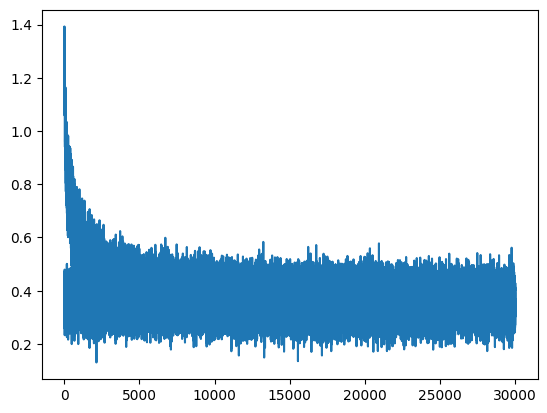

In [112]:
plt.plot(stepi,lossi)

In [117]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30)@W1 + b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits,Ydev)
loss

tensor(2.1469, grad_fn=<NllLossBackward0>)

In [118]:
emb = C[Xtr]
h = torch.tanh(emb.view(-1,30)@W1 + b1)
logits = h@W2+b2 
loss = F.cross_entropy(logits,Ytr)
loss

tensor(2.0957, grad_fn=<NllLossBackward0>)

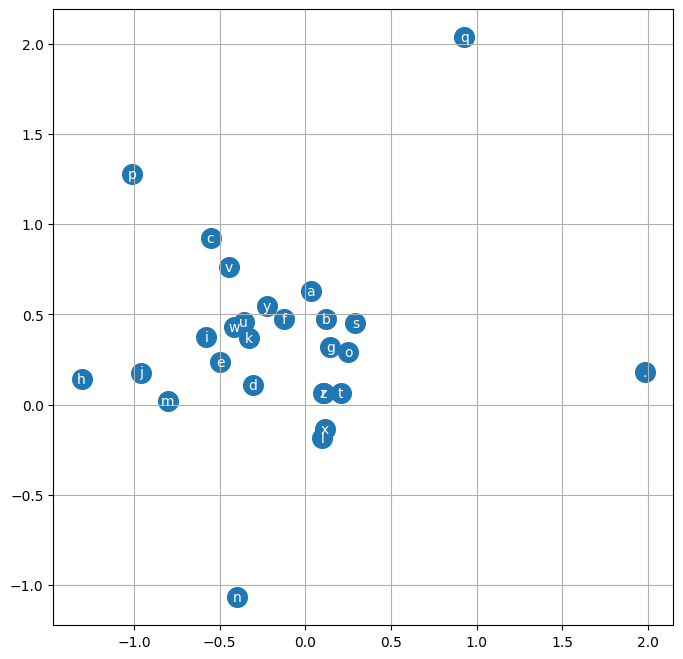

In [119]:
# Visualize the embedding vectors 

plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data,C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(),itos[i],ha="center",va='center',color='white')
plt.grid('minor')

In [122]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0]*block_size # init ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1,-1)@W1+b1)
        logits = h@W2+b2
        probs = F.softmax(logits,dim=1)
        ix = torch.multinomial(probs,num_samples=1,generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amelle.
khi.
mrex.
taty.
salaysie.
rahnen.
delyah.
jareei.
nellara.
chaiir.
kaleigh.
ham.
joia.
quintis.
lilah.
jadiq.
wazelo.
dearyxia.
kael.
